# 1. Importing the Data And Inspection

In [1]:
import pandas as pd
df = pd.read_csv("/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv")
df.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


# 2. Exploratory Data Analysis 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


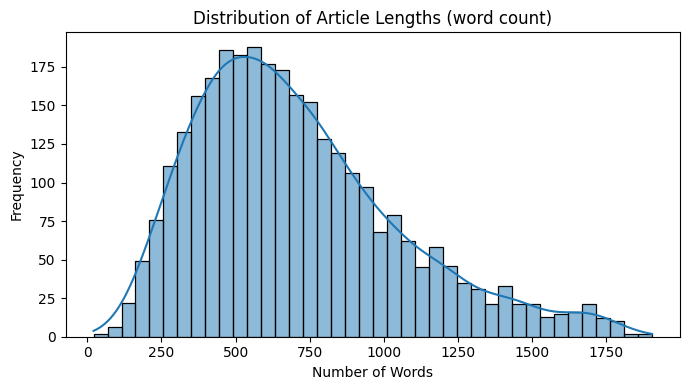

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


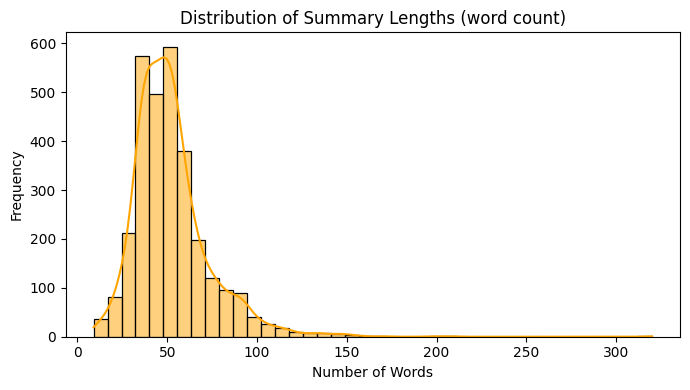

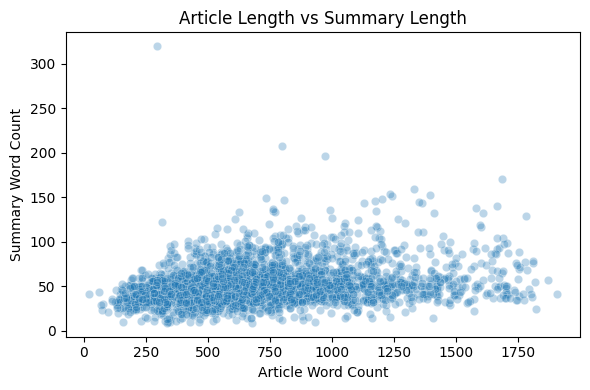

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


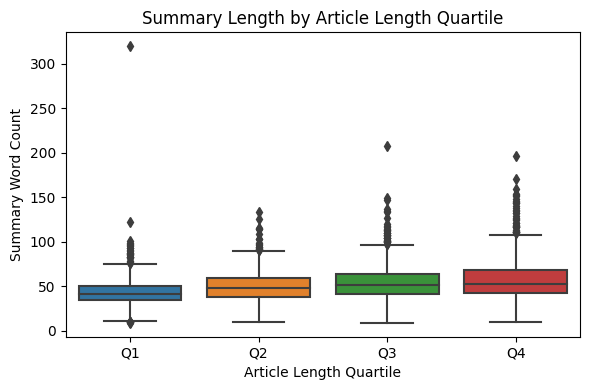

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


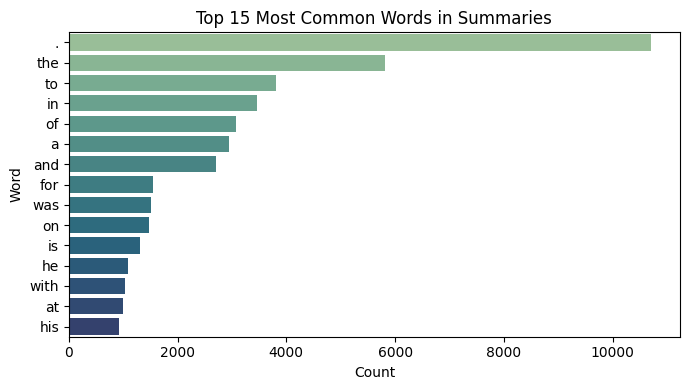

In [7]:
# ===================== EXPLORATORY DATA ANALYSIS (EDA) =====================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load a sample of the training set
train_path = "/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv"
df = pd.read_csv(train_path).dropna().sample(3000, random_state=42)

# Convert columns
df["article_len"] = df["article"].str.split().apply(len)
df["summary_len"] = df["highlights"].str.split().apply(len)

# ------------------ 1. Histogram: Article Length ----------------------------
plt.figure(figsize=(7,4))
sns.histplot(df["article_len"], bins=40, kde=True)
plt.title("Distribution of Article Lengths (word count)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ------------------ 2. Histogram: Summary Length ----------------------------
plt.figure(figsize=(7,4))
sns.histplot(df["summary_len"], bins=40, color="orange", kde=True)
plt.title("Distribution of Summary Lengths (word count)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ------------------ 3. Scatter: Article vs Summary Length -------------------
plt.figure(figsize=(6,4))
sns.scatterplot(x="article_len", y="summary_len", data=df, alpha=0.3)
plt.title("Article Length vs Summary Length")
plt.xlabel("Article Word Count")
plt.ylabel("Summary Word Count")
plt.tight_layout()
plt.show()

# ------------------ 4. Box Plot: Summary Length by Quartile of Article ------
df["article_bin"] = pd.qcut(df["article_len"], 4, labels=["Q1","Q2","Q3","Q4"])
plt.figure(figsize=(6,4))
sns.boxplot(x="article_bin", y="summary_len", data=df)
plt.title("Summary Length by Article Length Quartile")
plt.xlabel("Article Length Quartile")
plt.ylabel("Summary Word Count")
plt.tight_layout()
plt.show()

# ------------------ 5. Bar Plot: Most Common Words in Summaries -------------
from collections import Counter
from wordcloud import WordCloud

summary_words = " ".join(df["highlights"].tolist()).lower().split()
common_words = Counter(summary_words)
top_words = dict(common_words.most_common(15))

plt.figure(figsize=(7,4))
sns.barplot(x=list(top_words.values()), y=list(top_words.keys()), palette="crest")
plt.title("Top 15 Most Common Words in Summaries")
plt.xlabel("Count")
plt.ylabel("Word")
plt.tight_layout()
plt.show()
# ===========================================================================



# 3. Model Training 

In [5]:
# ================== FAST TRAINING: DOWNSAMPLED SUMMARIZER ===================
!pip install -q transformers datasets sentencepiece evaluate rouge-score

import os, pandas as pd, torch, numpy as np
from datasets import Dataset
from transformers import (AutoTokenizer, AutoModelForSeq2SeqLM,
                          DataCollatorForSeq2Seq, TrainingArguments, Trainer)
import evaluate

# ------------------- 1. CONFIG ---------------------------------------------------
MODEL_NAME   = "facebook/bart-large-cnn"
MAX_INPUT    = 512
MAX_TARGET   = 128
BATCH_SIZE   = 4
EPOCHS       = 1           # just 1 epoch to finish in 30–40 mins
LEARNING_RATE= 3e-5
OUTPUT_DIR   = "./bart_fast"

TRAIN_SIZE   = 2000        # reduced dataset sizes
VAL_SIZE     = 500
TEST_SIZE    = 200

# ------------------- 2. LOAD DATA ------------------------------------------------
paths = {
    "train": "/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv",
    "val":   "/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/validation.csv",
    "test":  "/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv"
}
def load_split(split_path, size):
    df = pd.read_csv(split_path)[["article", "highlights"]].dropna()
    df = df.sample(n=size, random_state=42).reset_index(drop=True)
    df = df.rename(columns={"article": "text", "highlights": "summary"})
    return Dataset.from_pandas(df)

data = {
    "train": load_split(paths["train"], TRAIN_SIZE),
    "val":   load_split(paths["val"], VAL_SIZE),
    "test":  load_split(paths["test"], TEST_SIZE),
}

# ------------------- 3. TOKENISATION ---------------------------------------------
tok = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess(batch):
    inputs  = tok(batch["text"], max_length=MAX_INPUT,  truncation=True, padding="max_length")
    targets = tok(batch["summary"], max_length=MAX_TARGET, truncation=True, padding="max_length")
    batch["input_ids"]      = inputs["input_ids"]
    batch["attention_mask"] = inputs["attention_mask"]
    batch["labels"]         = targets["input_ids"]
    return batch

tokenised = {k: v.map(preprocess, batched=True, remove_columns=v.column_names)
             for k,v in data.items()}

# ------------------- 4. MODEL + TRAINING SETUP ------------------------------------
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

args = TrainingArguments(
    output_dir                = OUTPUT_DIR,
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size  = BATCH_SIZE,
    num_train_epochs            = EPOCHS,
    fp16                        = torch.cuda.is_available(),
    save_total_limit            = 1,
    learning_rate               = LEARNING_RATE,
    weight_decay                = 0.01,
    logging_steps               = 100,
    save_strategy               = "epoch",
    report_to                   = "none"
)

rouge = evaluate.load("rouge")
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.where(preds != -100, preds, tok.pad_token_id)
    decoded_preds = tok.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tok.batch_decode(labels, skip_special_tokens=True)
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {k: round(v * 100, 2) for k, v in result.items()}

data_collator = DataCollatorForSeq2Seq(tok, model)

trainer = Trainer(
    model               = model,
    args                = args,
    train_dataset       = tokenised["train"],
    eval_dataset        = tokenised["val"],
    data_collator       = data_collator,
    tokenizer           = tok,
    compute_metrics     = compute_metrics,
)

# ------------------- 5. TRAIN -----------------------------------------------------
trainer.train()

# ------------------- 6. TEST & SAMPLE OUTPUT --------------------------------------
test_batch = tokenised["test"].select(range(5))
preds = model.generate(torch.tensor(test_batch["input_ids"]).to(model.device),
                       attention_mask=torch.tensor(test_batch["attention_mask"]).to(model.device),
                       max_length=MAX_TARGET, num_beams=4)
print("\n--- SAMPLE SUMMARIES ---")
for art, ref, pred in zip(data["test"]["text"][:5],
                          data["test"]["summary"][:5],
                          tok.batch_decode(preds, skip_special_tokens=True)):
    print(f"\nARTICLE: {art[:400]}...\nREF_SUMMARY: {ref}\nGEN_SUMMARY: {pred}")

# ------------------- 7. SAVE MODEL ------------------------------------------------
trainer.save_model(OUTPUT_DIR)
tok.save_pretrained(OUTPUT_DIR)
print(f"\n Model & tokenizer saved to {OUTPUT_DIR}")
# ================================================================================


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/tmp/ipykernel_36/248355853.py:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,1.581400
200,0.823900
300,0.825500
400,0.803400
500,0.736600


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(



--- SAMPLE SUMMARIES ---

ARTICLE: Comedian Jenny Eclair travelled with her other half on a Painting In Venus break with Flavours . There comes a time in a woman’s life when beach holidays just don’t cut it any longer, when lying on golden sands (unless you’re buried up to your neck) serves only to remind you how much weight you forgot to lose again this year and how ill-fitting your swimming costume is. Being control freaks, most ...
REF_SUMMARY: The comedian stayed with Flavours who offer a Painting In Venice break .
Jenny and her partner Geof stayed at the farmhouse Villa Bianchi .
Days involved sitting in medieval market towns with a brush and prosecco .
GEN_SUMMARY: Comedian Jenny Eclair travelled with her other half on a Painting In Venus break with Flavours .
An excursion to Venice one day provided inspiration for the budding artists .
The world is divided into those who still want to ‘give it large’ in Ibiza, and those who want to find their inner artist .

ARTICLE: A woman of

# 4. Model Evaluation and Rogue Score Comparison

/usr/local/lib/python3.11/dist-packages/transformers/models/bart/configuration_bart.py:176: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1730: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


ROUGE scores on 200-sample test set: {'rouge1': 8.2, 'rouge2': 3.45, 'rougeL': 6.08, 'rougeLsum': 7.75}


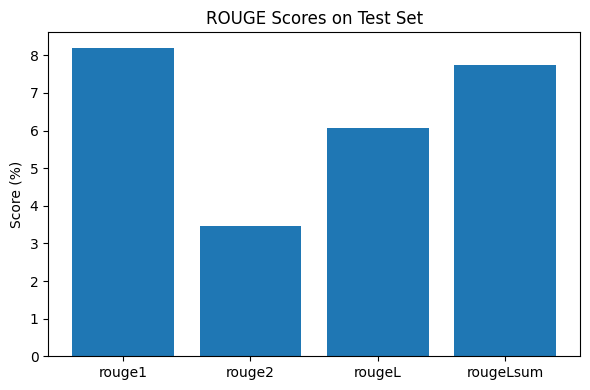

In [8]:
# ================= EVALUATION + VISUALS =================
import os, json, torch, pandas as pd, numpy as np, matplotlib.pyplot as plt, evaluate
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

MODEL_DIR = "./bart_fast"                     # where trainer saved the model
TEST_CSV  = "/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv"
TEST_SIZE = 200                               # same downsample size used for training
MAX_INPUT, MAX_TARGET = 512, 128

# 1) LOAD MODEL & TOKENIZER ----------------------------------------------------
tok   = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_DIR).to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# 2) PREP TEST DATA ------------------------------------------------------------
df_test = (pd.read_csv(TEST_CSV)
             .dropna()[["article","highlights"]]
             .sample(TEST_SIZE, random_state=42)
             .rename(columns={"article":"text","highlights":"summary"}))
test_ds = Dataset.from_pandas(df_test)

def preprocess(batch):
    tok_out = tok(batch["text"], max_length=MAX_INPUT, truncation=True, padding="max_length")
    batch["input_ids"]      = tok_out["input_ids"]
    batch["attention_mask"] = tok_out["attention_mask"]
    return batch

test_tok = test_ds.map(preprocess, batched=True)

# 3) GENERATE SUMMARIES --------------------------------------------------------
all_preds = []
for i in range(TEST_SIZE):
    inp_ids  = torch.tensor(test_tok[i]["input_ids"]).unsqueeze(0).to(model.device)
    attn_msk = torch.tensor(test_tok[i]["attention_mask"]).unsqueeze(0).to(model.device)
    summary_ids = model.generate(inp_ids, attention_mask=attn_msk,
                                 max_length=MAX_TARGET, num_beams=4)
    all_preds.append(tok.decode(summary_ids[0], skip_special_tokens=True))

# 4) ROUGE METRICS -------------------------------------------------------------
rouge = evaluate.load("rouge")
scores = rouge.compute(predictions=all_preds,
                       references=df_test["summary"].tolist(),
                       use_stemmer=True)
rouge_scores = {k: round(v * 100, 2) for k, v in scores.items()}
print("ROUGE scores on 200-sample test set:", rouge_scores)

# 5) VISUALISATIONS ------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.bar(list(rouge_scores.keys()), list(rouge_scores.values()))
plt.title("ROUGE Scores on Test Set")
plt.ylabel("Score (%)")
plt.tight_layout()
plt.show()

